In [1]:
#Final version - Bairds "7-star" counter-example
import numpy as np
from scipy.linalg import eig 
import mdptoolbox, mdptoolbox.example
import random
from numpy.random import seed
import time


def get_next_state(state,action):
    
    if action == 0:
        next_state = 6
    else:
        next_state = np.random.choice(6)
    
    return next_state
    
    
def feature_state(thetha,state):
    if state == 0:
        return 2*thetha[0] + thetha[7]
    if state == 1:
        return 2*thetha[1]+thetha[7]
    if state == 2:
        return 2*thetha[2]+thetha[7]
    if state == 3:
        return 2*thetha[3]+thetha[7]
    if state == 4:
        return 2*thetha[4]+thetha[7]
    if state == 5:
        return 2*thetha[5]+thetha[7]
    if state == 6:
        return thetha[6] + 2*thetha[7]



def grad_state(state):
    if state == 0:
        return np.array([2.0,0.0,0,0,0,0,0,1])
    if state == 1:
        return np.array([0.0,2.0,0,0,0,0,0,1])
    if state == 2:
        return np.array([0.0,0.0,2,0,0,0,0,1])
    if state == 3:
        return np.array([0.0,0.0,0,2,0,0,0,1])
    if state == 4:
        return np.array([0.0,0.0,0,0,2,0,0,1])
    if state == 5:
        return np.array([0.0,0.0,0,0,0,2,0,1])
    if state == 6:
        return np.array([0.0,0.0,0,0,0,0,1,2])
    

total_runs = 10
total_iterations = 1000000

step_size = 0.0001

error_storage_td = np.zeros((total_runs,total_iterations))
error_storage_ptd = np.zeros((total_runs,total_iterations))
error_storage_etd = np.zeros((total_runs,total_iterations))


for runs in range(total_runs):
    
    np.random.seed((runs+1)*100)
    random.seed((runs+1)*110)
    
    opt = np.array([[0,0,0,0,0,0,0]])

    
    thetha = [1,1,1,1,1,1,10,1]
    thetha_td = [1,1,1,1,1,1,10,1]
    discount = 0.99
    
    
    pi = np.array([[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]])
    mu = np.array([[1/7,6/7],[1/7,6/7],[1/7,6/7],[1/7,6/7],[1/7,6/7],[1/7,6/7],[1/7,6/7]])
        
    d_mu = np.array([[1/7,1/7,1/7,1/7,1/7,1/7,1/7]])
        
    eta = 1
    
    F=1
    thetha_ETD = [1,1,1,1,1,1,10,1]
    state = np.random.choice(7)
    for main_iter in range(total_iterations):
        
        action = np.random.choice(2,1,p=[1/7,6/7])[0]
        importance_sampling = pi[state,action]/mu[state,action]     
        next_state = get_next_state(state,action)


        grad = grad_state(state)
        
        delta = 0 + discount*feature_state(thetha_ETD,next_state) - feature_state(thetha_ETD,state)
        temp = F*importance_sampling*step_size*delta
        thetha_ETD = thetha_ETD + temp*grad

        delta = 0 + discount*feature_state(thetha,next_state) - (1+eta)*feature_state(thetha,state)
        temp2 = importance_sampling*step_size*delta
        thetha = thetha + temp2*grad
        
        delta = 0 + discount*feature_state(thetha_td,next_state) - feature_state(thetha_td,state)
        temp3 = importance_sampling*step_size*delta
        thetha_td = thetha_td + temp3*grad
        

        F = 1+ discount*importance_sampling*F 
        state = next_state
        
        v_ptd = np.zeros((7,1))
        v_etd = np.zeros((7,1))
        v_td =  np.zeros((7,1))
        
        for i in range(7):
            v_ptd[i,0] = feature_state(thetha,i)
            v_etd[i,0] = feature_state(thetha_ETD,i)
            v_td[i,0] = feature_state(thetha_td,i)
        
        error_storage_ptd[runs,main_iter] = np.sqrt(np.sum(np.multiply(d_mu.T,np.square(opt.T - v_ptd))))
        error_storage_etd[runs,main_iter] = np.sqrt(np.sum(np.multiply(d_mu.T,np.square(opt.T - v_etd))))
        error_storage_td[runs,main_iter] = np.sqrt(np.sum(np.multiply(d_mu.T,np.square(opt.T - v_td))))
        

        
print(thetha,thetha_ETD)



[ 1.69230769  1.69230769  1.69230769  1.69230769  1.69230769  1.69230769
  6.76923077 -3.38461538] [124301.36762851  97116.9135131  105729.46972231 106221.17278454
 135267.20277375 144625.91160799 170031.56795461 696672.1549243 ]


In [5]:
#Be careful. uncomment.
np.savetxt('Bairds-ptd-0.0001',np.average(error_storage_ptd,axis = 0))
np.savetxt('Bairds-etd-0.0001',np.average(error_storage_etd,axis = 0))
np.savetxt('Bairds-td-0.0001',np.average(error_storage_td,axis = 0))

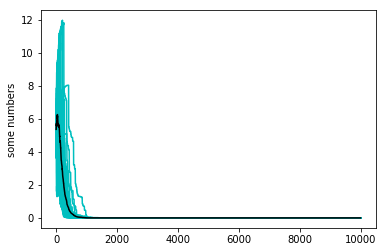

In [7]:
import matplotlib.pyplot as plt
for i in range(50):
    plt.plot(error_storage_ptd[i],'c',)
plt.plot(np.average(error_storage_ptd,axis = 0), 'k')
plt.ylabel('some numbers')
plt.show()

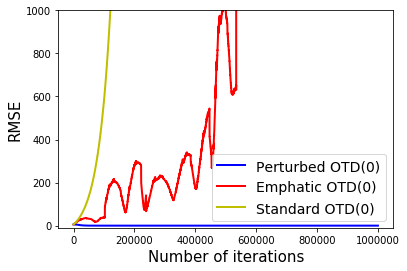

In [4]:
import matplotlib.pyplot as plt
plt.plot(np.average(error_storage_ptd,axis = 0), 'b',linewidth = 2, label = 'Perturbed OTD(0)')
plt.plot(np.average(error_storage_etd,axis = 0), 'r',linewidth = 2, label = 'Emphatic OTD(0)')
plt.plot(np.average(error_storage_td,axis = 0), 'y',linewidth = 2, label = 'Standard OTD(0)')
plt.ylim([-10,1000])

plt.legend(loc = 'best',prop={'size': 14})
plt.xlabel('Number of iterations',fontsize = 15)
plt.ylabel('RMSE',fontsize = 15)
plt.show()

In [ ]:
[ 1.69230769  1.69230769  1.69230769  1.69230769  1.69230769  1.69230769
  6.76923077 -3.38461538] [ 2.48767276  5.4755116   3.79845213  2.8853953   2.98696812  2.94870544
 40.4051001  69.10155286]